<a href="https://colab.research.google.com/github/MHzNug/Project-Analisis-Sentiment/blob/main/%5BPemodelan%5D%20Project_Analisis_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
!pip install google_play_scraper
!pip install Sastrawi
!pip install nltk
!pip install requests
!pip install transformers
!pip install torch

# **1. Import Library**

In [177]:
# Manipulasi Data
import pandas as pd
import numpy as np
import re
import string

# Visualisasi Data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Pengolahan Teks
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Pemrosesan Teks dan Preprocessing
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Pemodelan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **2. Memuat Dataset**

In [179]:
# Melihat DataFrame
df = pd.read_csv("https://raw.githubusercontent.com/MHzNug/Project-Analisis-Sentiment/refs/heads/main/Dataset/klikindomaret_reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,d74813b4-ef42-4670-9778-545a7333818a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Terimakasih atas kemudahan akses yang diberika...,5,26,2503200,2025-04-10 16:23:31,"Halo, Redmi Ujun. Terima kasih sudah berbelanj...",2025-04-10 16:30:11,2503200
1,a2b797cc-bfea-476d-ba9f-1aebb7e304c2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolong kembalikan versi klik dulu. supaya gamp...,4,0,2503200,2025-04-12 10:42:54,"Halo, Lailatul B. Terima kasih sudah berbelanj...",2025-04-12 11:00:15,2503200
2,600e548b-4dda-40ab-bf92-68325c700ab8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"untuk sementara bintang 4 dulu, sebenarnya ena...",4,7,2503200,2025-04-07 01:20:54,"Halo, Herna Herl. Terima kasih sudah berbelanj...",2025-04-07 01:30:11,2503200
3,dfde30e2-a5ac-4e5d-b298-969cc93f07f9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasinya sekarang parah, hari jumat 4 april...",1,45,2503200,2025-04-08 13:22:04,"Halo, Yuli Mifta. Mohon maaf atas kendala yang...",2025-04-08 13:30:13,2503200
4,36e959b9-c473-4aea-877a-bf257d974ecf,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,diberi info pesanan cancel karna jarak terlalu...,1,55,2503200,2025-03-29 02:52:31,"Halo, Dwi Yuni H. Mohon maaf atas kendala yang...",2025-03-29 03:00:16,2503200


In [180]:
# Jumlah data
len(df)

15000

# **3. Exploratory Data Analysis (EDA)**

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              15000 non-null  object        
 1   userName              15000 non-null  object        
 2   userImage             15000 non-null  object        
 3   content               15000 non-null  object        
 4   score                 15000 non-null  int64         
 5   thumbsUpCount         15000 non-null  int64         
 6   reviewCreatedVersion  12400 non-null  object        
 7   at                    15000 non-null  datetime64[ns]
 8   replyContent          12810 non-null  object        
 9   repliedAt             12810 non-null  datetime64[ns]
 10  appVersion            12400 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1.3+ MB


In [182]:
# Mengambil Data Score dan Review
df = df[['score', 'content']]
df.head()

,score,content
0,5,Terimakasih atas kemudahan akses yang diberika...
1,4,tolong kembalikan versi klik dulu. supaya gamp...
2,4,"untuk sementara bintang 4 dulu, sebenarnya ena..."
3,1,"aplikasinya sekarang parah, hari jumat 4 april..."
4,1,diberi info pesanan cancel karna jarak terlalu...


In [183]:
# Memeriksa Nilai yang Hilang
df.isnull().sum()

,0
score,0
content,0


In [184]:
# Memeriksa Data Duplikat
df.duplicated().sum()

np.int64(10)

In [185]:
# Menghapus Data Duplikat
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [186]:
# Data Setelah Menghapus Duplikat
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14990 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   score    14990 non-null  int64 
 1   content  14990 non-null  object
dtypes: int64(1), object(1)
memory usage: 351.3+ KB


In [187]:
# jumlah Data Setiap Scorenya
df['score'].value_counts()

,count
score,
1,6932
5,4679
2,1325
3,1213
4,841


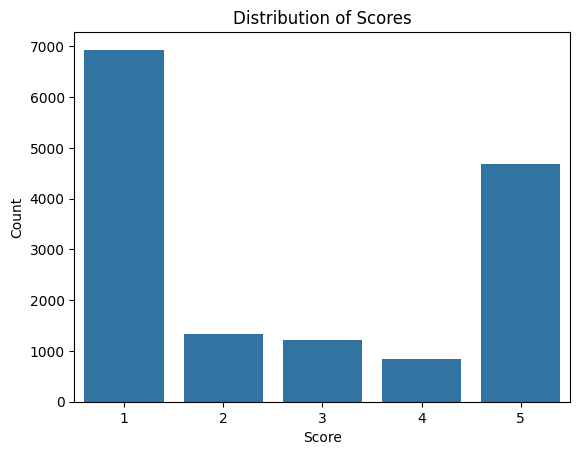

In [188]:
# Plot Score
sns.countplot(x='score', data=df)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

<ipython-input-189-d3864e4bbc60>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette='viridis')


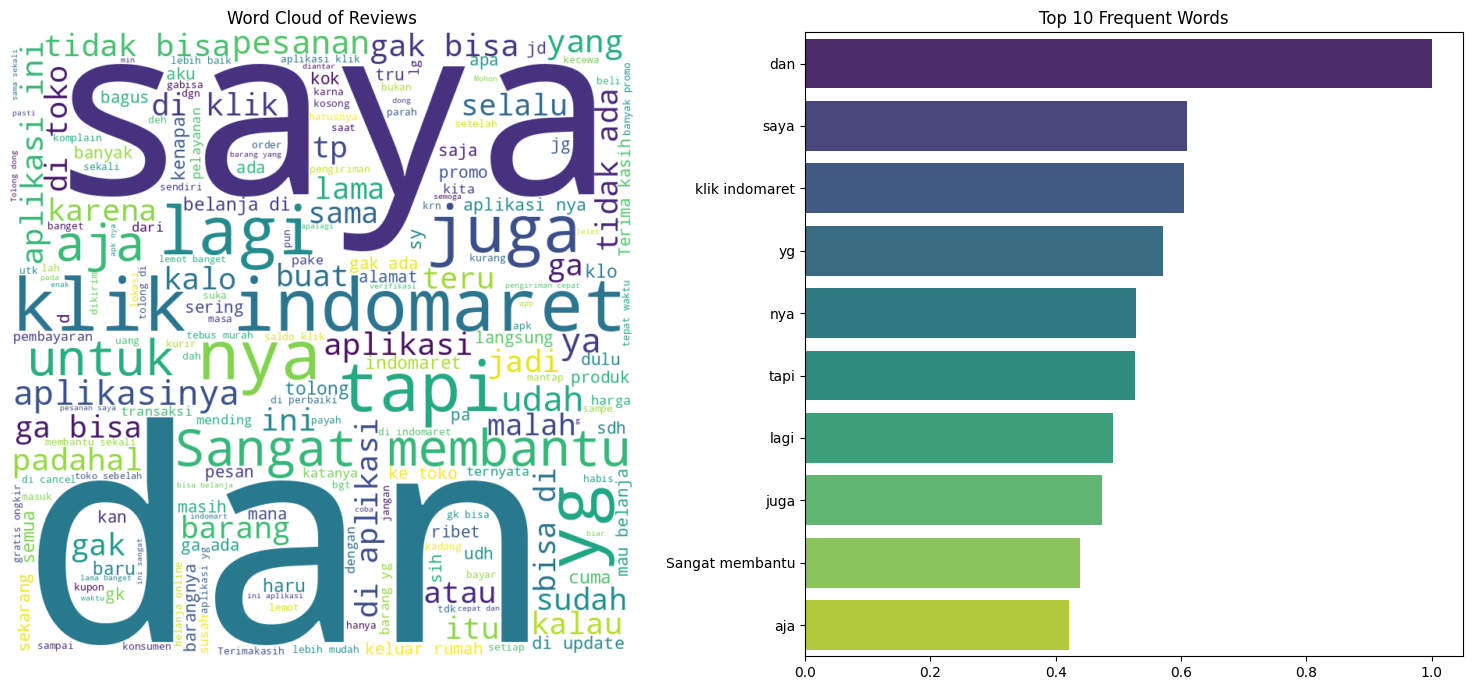

In [189]:
# Membuat Word Cloud
text = ' '.join(df['content'].tolist())
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Mendapatkan frekuensi kata dari wordcloud
frequencies = wordcloud.words_

# Menyiapkan data untuk barplot (10 kata paling sering)
words, counts = zip(*list(frequencies.items())[:10])

# Membuat subplots (2 kolom: WordCloud dan Barplot)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Menampilkan WordCloud
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Reviews')

# Menampilkan horizontal barplot
sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette='viridis')
axes[1].set_title('Top 10 Frequent Words')

# Menampilkan plot
plt.tight_layout()
plt.show()

# **4. Data Preprocessing**

In [190]:
# Membuat Fungsi untuk Memebersihkan Data Review
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus hashtag
    text = re.sub(r'RT[\s]', '', text)  # Menghapus RT
    text = re.sub(r"http\S+", '', text)  # Menghapus link
    text = re.sub(r'[0-9]+', '', text)  # Menghapus angka

    # Ganti tanda baca dengan spasi
    text = re.sub(r'[^\w\s]', ' ', text)  # Ganti tanda baca selain huruf dan angka dengan spasi

    text = text.replace('\n', ' ')  # Mengganti baris baru dengan spasi
    text = text.strip(' ')  # Menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(tokens): # Menghapus stopwords dalam teks
    stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def stemmingText(tokens): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return [stemmer.stem(word) for word in tokens]

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [191]:
url = "https://raw.githubusercontent.com/King-srt/Indonesia-Slang-Dictionary/refs/heads/main/dictionary_indonesia.txt"
response = requests.get(url)

# Inisialisasi dictionary kosong untuk menyimpan slang dan kata formal
slangwords = {}

# Ganti tanda kutip tunggal dengan tanda kutip ganda
cleaned_text = response.text.replace("’", "'")

for line in response.text.strip().split("\n"):
    if "," in line:
        slang, formal = line.strip().split(",", 1)
        slangwords[slang.strip()] = formal.strip()

# Menambahkan entri manual dalam bentuk dictionary
manual_entries = {
    "sy": "saya", "tul": "betul", "pa": "apa", "aqu": "aku", "cepa": "cepat", "coffie": "kopi",
    "sukaxbelanja": "suka sekali belanja", "luv": "suka", "sdiakan": "sediakan", "baguusss" : "bagus",
    "bagusteruskan": "bagus teruskan", "mantatatap": "mantap", "mantafz": "mantap", "mangtaps": "mantap",
    "mantabsss": "mantap", "oksss bgss": "oke bagus", "sukakkk": "suka", "benerr": "benar", "weeeeenak": "enak",
    "sukaaaa": "suka", "bangd": "banget", "bwat": "buat", "terbaiikkss": "terbaik", "mantabh": "mantap", "mantavvv": "mantap",
    "nya": "", "erorrrrrrrrrr": "eror", "aplikasinya": "aplikasi", "habi": "habis", "gabisa": "tidak bisa", "pesen": "pesan"

}

# Gabungkan dictionary manual ke dalam dictionary utama
slangwords.update(manual_entries)

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [192]:
# Positive Lexicon (manually extracted from the dataset)
positive_lexicon = set([
    "terimakasih", "kemudahan", "aplikasi", "klik", "indo", "mudah", "bintang", "enak", "belanja", "indomaret",
    "membantu", "bagus", "promo", "diskon", "hemat", "praktis", "user", "friendly", "fitur", "lengkap", "stabil",
    "cepat", "responsif", "nyaman", "bagus banget", "suka", "rekomendasi", "reliable", "bermanfaat", "layanan",
    "memuaskan", "pelayanan", "oke", "top", "top banget", "baik", "terpercaya", "cashback", "kece", "menyenangkan",
    "sukses", "berhasil", "solusi", "produk", "cocok", "sesuai", "bisa dipercaya", "lebih", "hemat", "mudah digunakan",
    "terbaik", "sangat membantu", "cepat tanggap", "pengalaman baik", "solusi cepat", "terlancar", "fitur kece",
    "top service", "sangat puas", "cocok banget", "bantu banget", "ga nyesel", "jempol", "paling oke", "pelayanan oke",
    "happy", "fast response", "fast service", "praktikal", "support cepat", "gampang banget", "sangat bagus",
    "sangat cepat", "perusahaan terpercaya", "no masalah", "value for money", "secepat kilat", "tidak mengecewakan",
    "super fast", "menarik", "terbantu", "baik banget", "sangat memuaskan", "akses cepat", "recommended"
])

# Negative Lexicon (manually extracted from the dataset)
negative_lexicon = set([
    "tolong", "parah", "lambat", "pesanan", "update", "keluhan", "masalah", "gagal", "batal", "kecewa", "susah",
    "error", "repot", "jelek", "tidak puas", "gagal transaksi", "kesulitan", "kerusakan", "tidak sesuai", "stres",
    "terganggu", "terlambat", "gangguan", "batal", "rusak", "kosong", "ketidaknyamanan", "menunggu", "tidak lancar",
    "kurang", "kesalahan", "keliru", "tidak efektif", "frustrasi", "kerusakan sistem", "kendala", "tidak nyaman",
    "sulit", "ribet", "terputus", "tiada solusi", "stagnan", "problem", "slow", "miskin", "cacat", "error transaksi",
    "tidak berhasil", "terhambat", "keterlambatan", "rumit", "tidak memuaskan", "error aplikasi", "kesulitan komunikasi",
    "tak bisa", "tak teratasi", "hambatan", "kekurangan", "terbengkalai", "pengiriman gagal", "tidak terjawab", "tunggu lama",
    "batal transaksi", "masalah pembayaran", "trouble", "tidak aman", "pembayaran gagal", "kerusakan produk",
    "gagal akses", "sistem error", "tidak sesuai harapan", "komplikasi", "kesulitan akses", "batal refund", "tidak efektif",
    "menyusahkan", "terlambat pengiriman", "tidak ada jawaban", "keterlambatan produk", "tidak direspon", "tidak dapat solusi",
    "tidak tersedia", "tidak ada", "kekurangan informasi", "lambat respon", "komplain", "cacat sistem", "kehilangan"
])


def sentiment(text, positive_lexicon = positive_lexicon, negative_lexicon = negative_lexicon):
    words = text.lower().split()

    positive_count = sum(1 for word in words if word in positive_lexicon)
    negative_count = sum(1 for word in words if word in negative_lexicon)

    if positive_count > negative_count:
        return 'Positif'
    elif negative_count > positive_count:
        return 'Negatif'
    else:
        return 'Netral'

In [193]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

# Membuat label sentiment
df['sentiment'] = df['text_akhir'].apply(sentiment)

In [194]:
df[['text_akhir', 'sentiment']].sample(10)

,text_akhir,sentiment
9153,harganya mahal offline harganya,Netral
14760,membantu aplikasi repot kehujanan kepanasan antre,Positif
3793,belanja minyak klik indomaret langsung toko be...,Positif
8158,proses terlupa password suruh verifikasi gak m...,Netral
1589,aplikasi parah lambat jelek kembalikan aplikas...,Positif
4281,aplikasi bagus lambat belanja buang fitur berk...,Positif
13004,drama pesanan dibayar dibatalkan refund uninst...,Negatif
12665,keren aplikasi coba belanja barusan terima kas...,Positif
3294,foto klik indomaret bermain pesanan error canc...,Negatif
10293,aplikasi lambat belanja butuh cepat loading ma...,Positif


In [195]:
df['sentiment'].value_counts()

,count
sentiment,
Positif,9174
Negatif,2973
Netral,2843


<ipython-input-196-23115a83a63e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['sentiment'].value_counts().index, y=df['sentiment'].value_counts().values, ax=axes[1], palette='viridis')


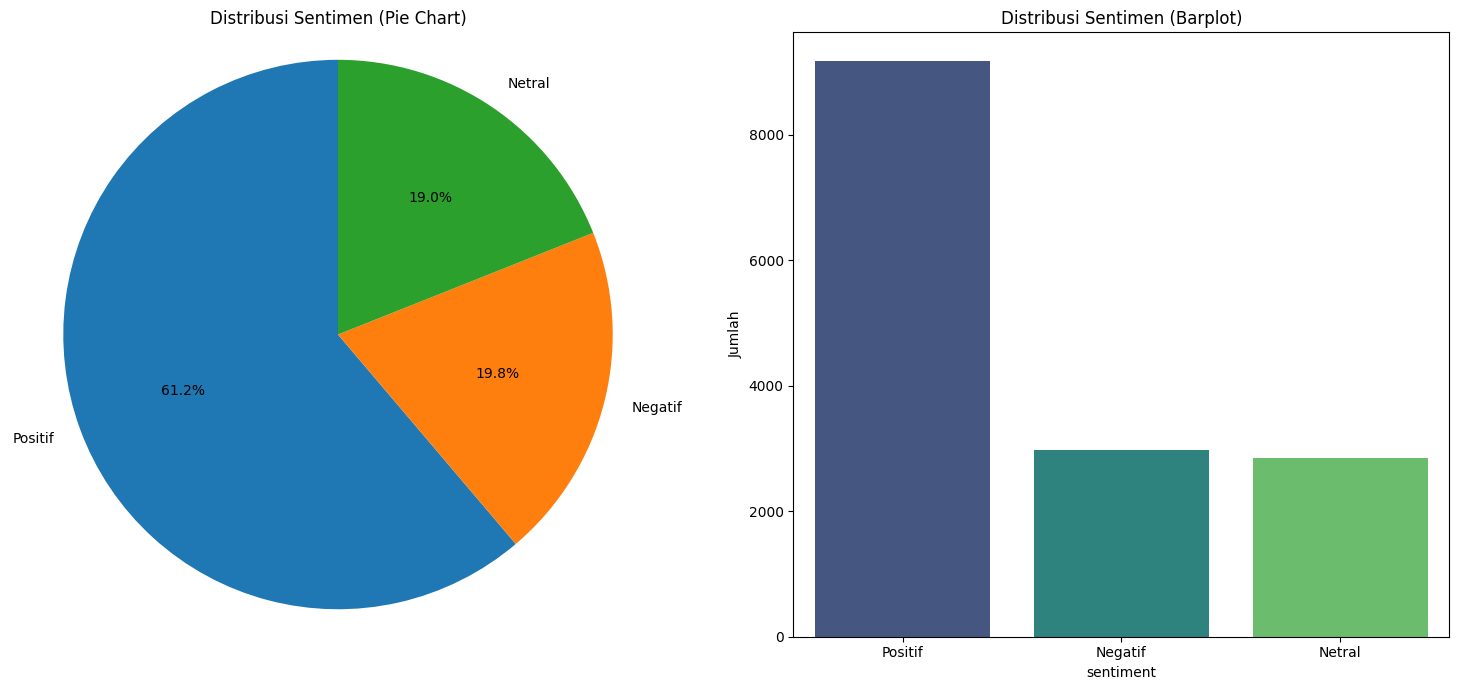

In [196]:

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Pie chart
axes[0].pie(df['sentiment'].value_counts(), labels=df['sentiment'].value_counts().index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribusi Sentimen (Pie Chart)')
axes[0].axis('equal')

# Barplot
sns.barplot(x=df['sentiment'].value_counts().index, y=df['sentiment'].value_counts().values, ax=axes[1], palette='viridis')
axes[1].set_title('Distribusi Sentimen (Barplot)')
axes[1].set_ylabel('Jumlah')

# Menampilkan plot
plt.tight_layout()
plt.show()


<ipython-input-197-14d03bdd7f9e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette='viridis')


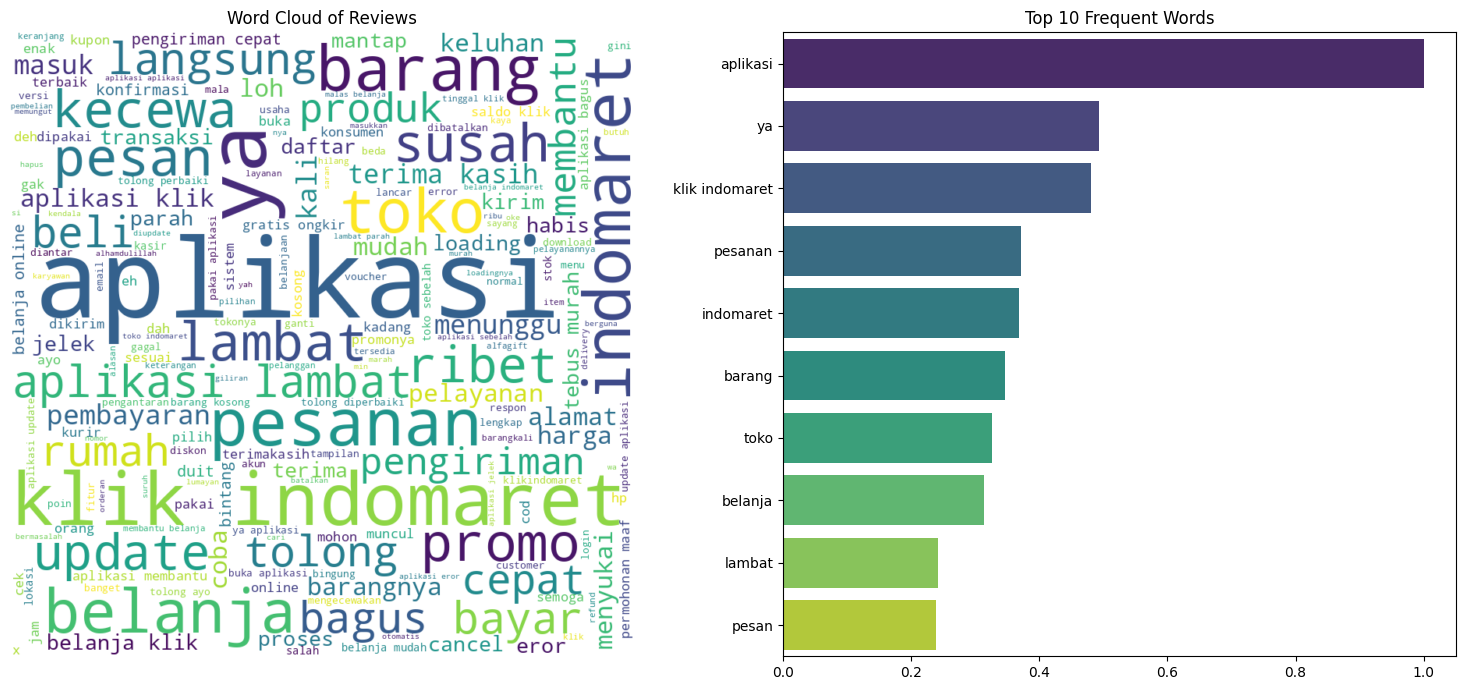

In [197]:
# Menggabungkan semua teks dari kolom 'text_akhir' yang sudah dibersihkan
text_cleaned = ' '.join(df['text_akhir'].dropna().tolist())

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text_cleaned)

# Mendapatkan frekuensi kata dari wordcloud
frequencies = wordcloud.words_

# Menyiapkan data untuk barplot (10 kata paling sering)
words, counts = zip(*list(frequencies.items())[:10])

# Membuat subplots (2 kolom: WordCloud dan Barplot)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Menampilkan WordCloud
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Reviews')

# Menampilkan horizontal barplot
sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette='viridis')
axes[1].set_title('Top 10 Frequent Words')

# Menampilkan plot
plt.tight_layout()
plt.show()

# **5. Pembangunan Model**

In [199]:
lebel_mapping = {'Positif': 2, 'Netral': 1, 'Negatif': 0}
df['sentiment_target'] = df['sentiment'].map(lebel_mapping)

In [205]:
X = df['text_akhir']
y = df['sentiment_target']

# Ekstraksi fitur
tokenizer = Tokenizer(num_words=10000)  # Limit to top 10,000 words
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, padding='post', maxlen=100)
y = to_categorical(y, num_classes=3)

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])

Jumlah data latih: 11992
Jumlah data uji: 2998


## Skema 1 RNN BI dengan Embeding

In [209]:
# Membuat Model RNN
rnn_model = Sequential()

# Layer embedding
rnn_model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))

# Menambahkan lapisan RNN
rnn_model.add(SpatialDropout1D(0.2))
rnn_model.add(Bidirectional(SimpleRNN(100, dropout=0.2, recurrent_dropout=0.2)))
rnn_model.add(Dense(3, activation='softmax'))  # 3 kelas: positive, neutral, negative

# Menyusun model
rnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Ringkasan model
rnn_model.build(input_shape=(None, 64))
rnn_model.summary()

# Melatih model RNN
rnn_history = rnn_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ (None, 64, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 64, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 200)            │        45,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,326,403 (5.06 MB)

 Trainable params: 1,326,403 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 - 73s - 98ms/step - accuracy: 0.6456 - loss: 0.8127 - val_accuracy: 0.7789 - val_loss: 0.5190
Epoch 2/10
750/750 - 84s - 112ms/step - accuracy: 0.7620 - loss: 0.5397 - val_accuracy: 0.8122 - val_loss: 0.4871
Epoch 3/10
750/750 - 77s - 103ms/step - accuracy: 0.8034 - loss: 0.4755 - val_accuracy: 0.7999 - val_loss: 0.5024
Epoch 4/10
750/750 - 66s - 88ms/step - accuracy: 0.8279 - loss: 0.4183 - val_accuracy: 0.8789 - val_loss: 0.3675
Epoch 5/10
750/750 - 84s - 112ms/step - accuracy: 0.8788 - loss: 0.3159 - val_accuracy: 0.8416 - val_loss: 0.4219
Epoch 6/10
750/750 - 86s - 114ms/step - accuracy: 0.9075 - loss: 0.2450 - val_accuracy: 0.9013 - val_loss: 0.3215
Epoch 7/10
750/750 - 78s - 104ms/step - accuracy: 0.9241 - loss: 0.2203 - val_accuracy: 0.9166 - val_loss: 0.2416
Epoch 8/10
750/750 - 78s - 104ms/step - accuracy: 0.9236 - loss: 0.2125 - val_accuracy: 0.9043 - val_loss: 0.2629
Epoch 9/10
750/750 - 89s - 119ms/step - accuracy: 0.9384 - loss: 0.1839 - val_accuracy: 0.

In [210]:
# Evaluasi Model
train_loss, train_accuracy = rnn_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Train Accuracy: 0.9771
Test Accuracy: 0.9213


## Skema 2 LSTM BI dengan Embeding Layer

In [219]:
# LSTM model
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Model summary
lstm_model.build(input_shape=(None, 64))
lstm_model.summary()

# Train the model
stop = EarlyStopping(monitor='val_accuracy', patience=0, restore_best_weights=True, baseline=0.92, mode='max')
lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=2, callbacks=[stop])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_38 (Embedding)        │ (None, 64, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,379,203 (5.26 MB)

 Trainable params: 1,379,203 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 - 84s - 112ms/step - accuracy: 0.8632 - loss: 0.3486 - val_accuracy: 0.9623 - val_loss: 0.1214
Epoch 2/10
750/750 - 82s - 110ms/step - accuracy: 0.9710 - loss: 0.0948 - val_accuracy: 0.9743 - val_loss: 0.0729
Epoch 3/10
750/750 - 81s - 108ms/step - accuracy: 0.9872 - loss: 0.0475 - val_accuracy: 0.9466 - val_loss: 0.2056


In [220]:
# Evaluasi Model
train_loss, train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Train Accuracy: 0.9855
Test Accuracy: 0.9743


## Skema 3 GRU tanpa TF-IDF

In [226]:
X = df['text_akhir']
y = df['sentiment_target']

tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(X).toarray()

y = to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [233]:
# GRU Model
gru_model = Sequential()
gru_model.add(GRU(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, dropout=0.2))
gru_model.add(Dense(3, activation='softmax'))

# Compile model
gru_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Model summary
gru_model.summary()

gru_history = gru_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_13 (GRU)                    │ (None, 100)            │     3,030,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,030,903 (11.56 MB)

 Trainable params: 3,030,903 (11.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 - 56s - 74ms/step - accuracy: 0.7211 - loss: 0.6376 - val_accuracy: 0.8616 - val_loss: 0.3940
Epoch 2/10
750/750 - 67s - 90ms/step - accuracy: 0.8323 - loss: 0.4349 - val_accuracy: 0.8252 - val_loss: 0.3813
Epoch 3/10
750/750 - 34s - 45ms/step - accuracy: 0.8566 - loss: 0.3720 - val_accuracy: 0.8482 - val_loss: 0.3736
Epoch 4/10
750/750 - 41s - 54ms/step - accuracy: 0.8704 - loss: 0.3372 - val_accuracy: 0.8309 - val_loss: 0.4116
Epoch 5/10
750/750 - 34s - 45ms/step - accuracy: 0.8847 - loss: 0.3104 - val_accuracy: 0.8282 - val_loss: 0.4279
Epoch 6/10
750/750 - 35s - 47ms/step - accuracy: 0.8886 - loss: 0.2908 - val_accuracy: 0.8122 - val_loss: 0.4500
Epoch 7/10
750/750 - 39s - 53ms/step - accuracy: 0.8898 - loss: 0.2851 - val_accuracy: 0.7989 - val_loss: 0.4914
Epoch 8/10
750/750 - 39s - 53ms/step - accuracy: 0.8942 - loss: 0.2775 - val_accuracy: 0.7912 - val_loss: 0.5166
Epoch 9/10
750/750 - 42s - 55ms/step - accuracy: 0.8980 - loss: 0.2682 - val_accuracy: 0.8005 - 

In [234]:
# Evaluasi Model
train_loss, train_accuracy = gru_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = gru_model.evaluate(X_test, y_test, verbose=0)
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Train Accuracy: 0.9755
Test Accuracy: 0.7945


In [238]:
# Simpan model
rnn_model.save("model_rnn.h5")
lstm_model.save("model_lstm.h5")
gru_model.save("model_gru.h5")

In [243]:
import tensorflow as tf

# Konversi model GRU ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(gru_model)

# Tentukan ops yang didukung oleh TFLite
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Lakukan konversi
tflite_model = converter.convert()

# Menyimpan model TFLite
with open('model_gru.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpvzvegm5_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 10000), dtype=tf.float32, name='keras_tensor_240')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137146767424208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146767421712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146767423632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146767423056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146767424592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137146711644816: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [236]:
import pickle

# Simpan tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [240]:
!pip freeze > requirements.txt